# Build two agents to play chess game

## Steps
- Define actions for players including BoardMove, BoardView and LegalMoves

- Define the player agent class

- Begin the Chess game !!!


In [1]:
from typing import List
from agentlite.actions import BaseAction
from agentlite.agents import ABCAgent, BaseAgent
from agentlite.llm.agent_llms import BaseLLM, get_llm_backend
from agentlite.llm.LLMConfig import LLMConfig
from agentlite.logging.multi_agent_log import AgentLogger
import chess
import chess.svg
from IPython.display import display
from env import openai_api_key

## Define the actions for chess players
- BoardMove: Make a move on the board

- BoardView: View current status
- LegalMoves: Find all the legal moves on board situation

Each action should have action_name, action_desc and params_doc

In [2]:
# Define the chess board
BOARD = chess.Board()

# Define the Move action to make a move on the board
class BoardMove(BaseAction):
    def __init__(self) -> None:
        action_name = "BoardMove"
        action_desc = "Using this action to move a step on chess board"
        params_doc = {"query": "Standard Universal Chess Interface Move"}
        super().__init__(
            action_name=action_name,
            action_desc=action_desc,
            params_doc=params_doc,
        )

    def __call__(self, query):
        try:
            BOARD.push_uci(query)
        except ValueError as e:
            return f"Error: {e}. The movement is illegal. I need to find a legal move with LegalMoves action."

        else:
            m = chess.Move.from_uci(query)
            display(
                chess.svg.board(
                    BOARD, arrows = [(m.from_square, m.to_square)], fill = {m.from_square: "gray"}, size = 200
                )
            )
        return f"Moved on board, move is {query}. I should finish my turn."

# Define the View action to have a look at the board    
class BoardView(BaseAction):
    def __init__(self) -> None:
        action_name = "BoardView"
        action_desc = "Get the Forsyth-Edwards Notation of current board status"
        params_doc = {"key": "True"}
        super().__init__(
            action_name = action_name,
            action_desc = action_desc,
            params_doc = params_doc
        )

    def __call__(self, key, **kwargs):
        return BOARD.fen()

# Define the legalmoves action to find legal moves 
class LegalMoves(BaseAction):
    def __init__(self) -> None:
        action_name = "LegalMoves"
        action_desc = "Get the legal moves of current board status"
        params_doc = {"key": "True"}
        super().__init__(
            action_name = action_name,
            action_desc = action_desc,
            params_doc = params_doc
        )
    
    def __call__(self, key):
        legal_moves = list(BOARD.legal_moves)
        legal_moves = [m.uci() for m in legal_moves]
        return ', '.join(legal_moves)


## Define the player agent class
- It can take the BoardMove(), BoardView() and LegalMoves() action

- It should have the name and role property

In [3]:
## using the agentrool logger to record the running log
agent_logger = AgentLogger(PROMPT_DEBUG_FLAG=False)

# Define the Chess Player agent class
class ChessPlayerAgent(BaseAgent):
    def __init__(
        self,
        llm: BaseLLM,
        actions: List[BaseAction] = [BoardMove(), BoardView(), LegalMoves()], # we add both actions into agents
        manager: ABCAgent = None,
        color = "",
        **kwargs
    ):
        if color not in ["white", "black"]:
            raise ValueError(f"color must be either white or black, but got {color}")
        opponent_color = "black" if color == "white" else "white"
        
        name = f"{color}_player"
        opponent_name = f"{opponent_color}_player"

        role = f"""Your name is {name} and you are a chess player. You are playing against {opponent_name}. You are playing as {color}. """
        constraint = """You communicate your move using universal chess interface language. 
        Step1: View the board with BoardView action. 
        Step2: Get the legal moves with LegalMoves action. 
        Step3: Make a legal move using BoardMove action.
        """
        super().__init__(
            name=name,
            role=role,
            llm=llm,
            actions=actions,
            manager=manager,
            logger=agent_logger,
            constraints=constraint
        )


## Initialize the agent
- Initialize LLM, remember to get your own openai_api

- Initialize player_white and player_black
- Add illustration example to the player agents

In [4]:
# Initialize LLM
llm_config_dict = {"llm_name": "gpt-4-32k", "temperature": 0.0, "openai_api_key": openai_api_key}
llm_config = LLMConfig(llm_config_dict)
llm = get_llm_backend(llm_config)

# Initialize the two player agent
player_white = ChessPlayerAgent(llm = llm, color = "white")
player_black = ChessPlayerAgent(llm = llm, color = "black")

In [5]:
# adding example to ChessPlayerAgent to make it stable. 
from agentlite.commons import AgentAct, TaskPackage
from agentlite.actions import ThinkAct, FinishAct
from agentlite.actions.InnerActions import INNER_ACT_KEY

exp_task = "It is your turn."
exp_task_pack = TaskPackage(instruction=exp_task)
act_1 = AgentAct(
    name=BoardView().action_name,
    params={"key": "True"
    },
)
obs_1 = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"

act_2 = AgentAct(
    name=LegalMoves().action_name,
    params={"key": "True",
        },
)
obs_2 = """g1h3, g1f3, b1c3, b1a3, h2h3, g2g3, f2f3, e2e3, d2d3, c2c3, b2b3, a2a3, h2h4, g2g4, f2f4, e2e4, d2d4, c2c4, b2b4, a2a4"""

act_3 = AgentAct(
    name=BoardMove().action_name,
    params={"query": "g1h3",
        },
)
obs_3 = """Moved on board, move is g1h3. It is opponent's turn next."""

act_4 = AgentAct(name=FinishAct.action_name, params={INNER_ACT_KEY: "Chess Moved. It's my opponent's turn."})
obs_4 = "Task Completed."
exp_act_obs = [(act_1, obs_1), (act_2, obs_2), (act_3, obs_3), (act_4, obs_4)]

player_white.prompt_gen.add_example(
    task = exp_task_pack, action_chain = exp_act_obs
)
player_black.prompt_gen.add_example(
    task = exp_task_pack, action_chain = exp_act_obs 
)


## Play the game !!!


Agent white_player receives the following TaskPackage:
[
	Task ID: 2ab2d8da-5c46-4fc2-b4c6-b781c9be5e78
	Instruction: It is your turn
]
====white_player starts execution on TaskPackage 2ab2d8da-5c46-4fc2-b4c6-b781c9be5e78====


/Users/liangwei.yang/miniconda3/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Agent white_player takes 0-step Action:
{
	name: LegalMoves
	params: {'key': 'True'}
}
Observation: g1h3, g1f3, b1c3, b1a3, h2h3, g2g3, f2f3, e2e3, d2d3, c2c3, b2b3, a2a3, h2h4, g2g4, f2f4, e2e4, d2d4[TLDR]
Agent white_player takes 1-step Action:
{
	name: BoardMove
	params: {'query': 'g1h3'}
}


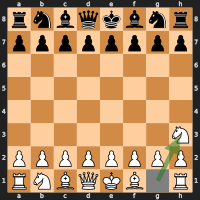

Observation: Moved on board, move is g1h3. I should finish my turn.
Agent white_player takes 2-step Action:
{
	name: Finish
	params: {'response': "It's my opponent's turn now. I need to think about my next move."}
}
Observation: Task Completed.
=========white_player finish execution. TaskPackage[ID:2ab2d8da-5c46-4fc2-b4c6-b781c9be5e78] status:
[
	completion: completed
	answer: It's my opponent's turn now. I need to think about my next move.
]
Agent black_player receives the following TaskPackage:
[
	Task ID: 2ab2d8da-5c46-4fc2-b4c6-b781c9be5e78
	Instruction: It is your turn
]
====black_player starts execution on TaskPackage 2ab2d8da-5c46-4fc2-b4c6-b781c9be5e78====
Agent black_player takes 0-step Action:
{
	name: BoardView
	params: {'key': 'True'}
}
Observation: rnbqkbnr/pppppppp/8/8/8/7N/PPPPPPPP/RNBQKB1R b KQkq - 1 1
Agent black_player takes 1-step Action:
{
	name: LegalMoves
	params: {'key': 'True'}
}
Observation: g8h6, g8f6, b8c6, b8a6, h7h6, g7g6, f7f6, e7e6, d7d6, c7c6, b7b6, a7a6

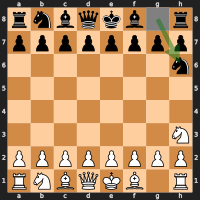

Observation: Moved on board, move is g8h6. I should finish my turn.
Agent black_player takes 4-step Action:
{
	name: Finish
	params: {'response': 'I moved my knight to h6.'}
}
Observation: Task Completed.
=========black_player finish execution. TaskPackage[ID:2ab2d8da-5c46-4fc2-b4c6-b781c9be5e78] status:
[
	completion: completed
	answer: I moved my knight to h6.
]
Agent white_player receives the following TaskPackage:
[
	Task ID: 2ab2d8da-5c46-4fc2-b4c6-b781c9be5e78
	Instruction: It is your turn
]
====white_player starts execution on TaskPackage 2ab2d8da-5c46-4fc2-b4c6-b781c9be5e78====
Agent white_player takes 0-step Action:
{
	name: LegalMoves
	params: {'key': 'True'}
}
Observation: h3g5, h3f4, h3g1, h1g1, b1c3, b1a3, g2g3, f2f3, e2e3, d2d3, c2c3, b2b3, a2a3, g2g4, f2f4, e2e4, d2d4[TLDR]
Agent white_player takes 1-step Action:
{
	name: BoardMove
	params: {'query': 'h3f4'}
}


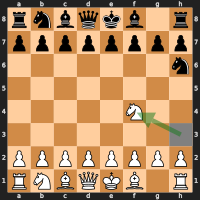

Observation: Moved on board, move is h3f4. I should finish my turn.
Agent white_player takes 2-step Action:
{
	name: Finish
	params: {'response': "Chess Moved. It's my opponent's turn."}
}
Observation: Task Completed.
=========white_player finish execution. TaskPackage[ID:2ab2d8da-5c46-4fc2-b4c6-b781c9be5e78] status:
[
	completion: completed
	answer: Chess Moved. It's my opponent's turn.
]
Agent black_player receives the following TaskPackage:
[
	Task ID: 2ab2d8da-5c46-4fc2-b4c6-b781c9be5e78
	Instruction: It is your turn
]
====black_player starts execution on TaskPackage 2ab2d8da-5c46-4fc2-b4c6-b781c9be5e78====
Agent black_player takes 0-step Action:
{
	name: LegalMoves
	params: {'key': 'True'}
}
Observation: h8g8, b8c6, b8a6, h6g8, h6f5, h6g4, g7g6, f7f6, e7e6, d7d6, c7c6, b7b6, a7a6, g7g5, f7f5, e7e5, d7d5[TLDR]
Agent black_player takes 1-step Action:
{
	name: BoardMove
	params: {'query': 'h8g8'}
}


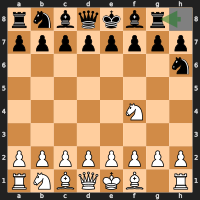

Observation: Moved on board, move is h8g8. I should finish my turn.
Agent black_player takes 2-step Action:
{
	name: Finish
	params: {'response': "Chess Moved. It's your opponent's turn."}
}
Observation: Task Completed.
=========black_player finish execution. TaskPackage[ID:2ab2d8da-5c46-4fc2-b4c6-b781c9be5e78] status:
[
	completion: completed
	answer: Chess Moved. It's your opponent's turn.
]
Agent white_player receives the following TaskPackage:
[
	Task ID: 2ab2d8da-5c46-4fc2-b4c6-b781c9be5e78
	Instruction: It is your turn
]
====white_player starts execution on TaskPackage 2ab2d8da-5c46-4fc2-b4c6-b781c9be5e78====
Agent white_player takes 0-step Action:
{
	name: LegalMoves
	params: {'key': 'True'}
}
Observation: f4g6, f4e6, f4h5, f4d5, f4h3, f4d3, h1g1, b1c3, b1a3, h2h3, g2g3, f2f3, e2e3, d2d3, c2c3, b2b3, a2a3[TLDR]
Agent white_player takes 1-step Action:
{
	name: BoardMove
	params: {'query': 'f4e6'}
}


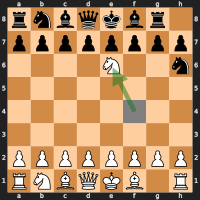

Observation: Moved on board, move is f4e6. I should finish my turn.
Agent white_player takes 2-step Action:
{
	name: Finish
	params: {'response': "Chess Moved. It's my turn again."}
}
Observation: Task Completed.
=========white_player finish execution. TaskPackage[ID:2ab2d8da-5c46-4fc2-b4c6-b781c9be5e78] status:
[
	completion: completed
	answer: Chess Moved. It's my turn again.
]
Agent black_player receives the following TaskPackage:
[
	Task ID: 2ab2d8da-5c46-4fc2-b4c6-b781c9be5e78
	Instruction: It is your turn
]
====black_player starts execution on TaskPackage 2ab2d8da-5c46-4fc2-b4c6-b781c9be5e78====
Agent black_player takes 0-step Action:
{
	name: BoardView
	params: {'key': 'True'}
}
Observation: rnbqkbr1/pppppppp/4N2n/8/8/8/PPPPPPPP/RNBQKB1R b KQq - 5 3
Agent black_player takes 1-step Action:
{
	name: LegalMoves
	params: {'key': 'True'}
}
Observation: g8h8, b8c6, b8a6, h6f5, h6g4, f7e6, d7e6, g7g6, f7f6, d7d6, c7c6, b7b6, a7a6, g7g5, f7f5, d7d5, c7c5[TLDR]
Agent black_player takes 2

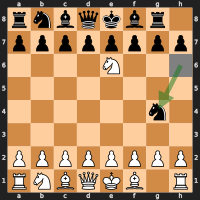

Observation: Moved on board, move is h6g4. I should finish my turn.
Agent black_player takes 3-step Action:
{
	name: Finish
	params: {'response': "Chess moved. It's your opponent's turn."}
}
Observation: Task Completed.
=========black_player finish execution. TaskPackage[ID:2ab2d8da-5c46-4fc2-b4c6-b781c9be5e78] status:
[
	completion: completed
	answer: Chess moved. It's your opponent's turn.
]


In [6]:
num_round = 3
for i in range(num_round):
    exp_task = "It is your turn"
    exp_task_pack = TaskPackage(instruction=exp_task)
    player_white(exp_task_pack)

    exp_task = "It is your turn"
    exp_task_pack = TaskPackage(instruction=exp_task)
    player_black(exp_task_pack)